# **Survival Analysis for Colorectal Cancer Patients**

## **Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
import lifelines

## **EDA**

In [2]:
cancer_df = pd.read_csv('data/Colorectal Cancer Patient Data.csv')
display(cancer_df.head())

,Unnamed: 0,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
0,0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0
1,1,GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0
2,2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0
3,3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0
4,4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0


In [3]:
# Drop columns: "unnamed: 0", "ID_REF"
cancer_df = cancer_df.drop(columns=["Unnamed: 0", "ID_REF"], errors='ignore')

In [4]:
display(cancer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age (in years)   62 non-null     float64
 1   Dukes Stage      62 non-null     object 
 2   Gender           62 non-null     object 
 3   Location         62 non-null     object 
 4   DFS (in months)  62 non-null     float64
 5   DFS event        62 non-null     float64
 6   Adj_Radio        62 non-null     float64
 7   Adj_Chem         62 non-null     float64
dtypes: float64(5), object(3)
memory usage: 4.1+ KB


None

In [5]:
display(cancer_df.describe())

,Age (in years),DFS (in months),DFS event,Adj_Radio,Adj_Chem
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,61.112903,41.774194,0.596774,0.532258,0.483871
std,9.581582,26.288076,0.494550,0.503032,0.503819
min,28.000000,4.000000,0.000000,0.000000,0.000000
25%,56.250000,19.500000,0.000000,0.000000,0.000000
50%,62.000000,38.000000,1.000000,1.000000,0.000000
75%,67.000000,57.500000,1.000000,1.000000,1.000000
max,78.000000,108.000000,1.000000,1.000000,1.000000


In [6]:
# Count missing values
display(cancer_df.isnull().sum())

Age (in years)     1
Dukes Stage        1
Gender             1
Location           1
DFS (in months)    1
DFS event          1
Adj_Radio          1
Adj_Chem           1
dtype: int64

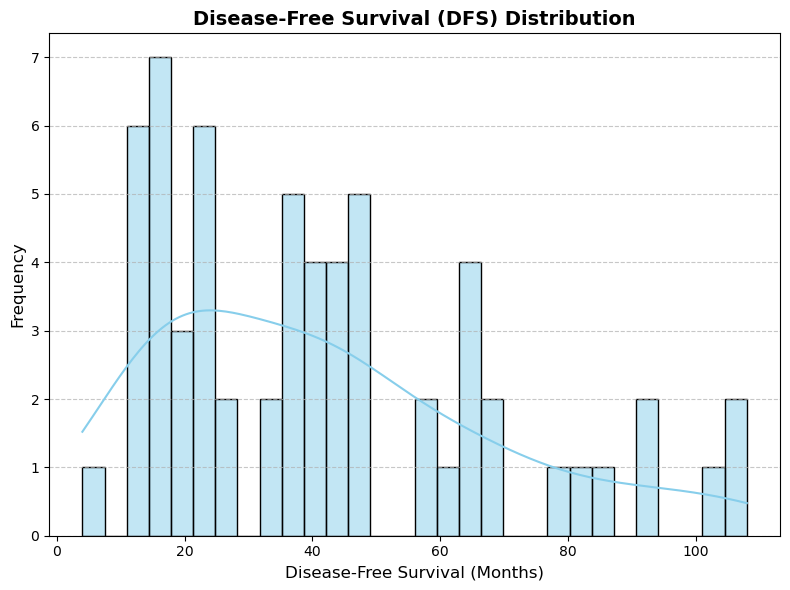

In [7]:
# Plot the histogram using Seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.histplot(
    data=cancer_df, 
    x='DFS (in months)', 
    bins=30, 
    kde=True,
    color='skyblue', 
    edgecolor='black'
)

plt.title("Disease-Free Survival (DFS) Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Disease-Free Survival (Months)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

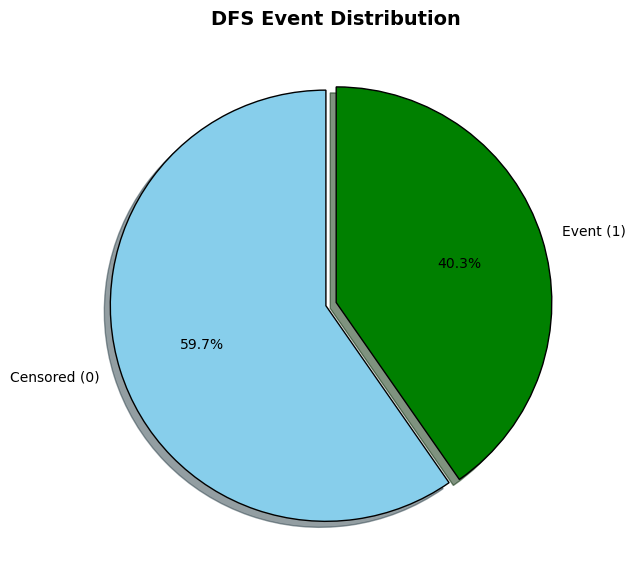

In [8]:
# Count the values for DFS event
dfs_event_counts = cancer_df['DFS event'].value_counts()

fig, ax = plt.subplots(figsize=(7, 7))
colors = ['skyblue', 'green']
explode = [0.05, 0]

ax.pie(
    dfs_event_counts,
    labels=['Censored (0)', 'Event (1)'],
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'black'}
)

ax.set_title("DFS Event Distribution", fontsize=14, fontweight='bold')

plt.show()

## **Preprocessing**

In [9]:
# Define feature groups
numeric_features = ['Age (in years)', 'Adj_Radio', 'Adj_Chem']
categorical_features = ['Location']
binary_features = ['Gender']
ordinary_features = ['Dukes Stage']
survival_features = ['DFS (in months)', 'DFS event']

preprocessor = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler()
        ),
        numeric_features,
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown="ignore")
        ),
        categorical_features,
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(drop="if_binary", handle_unknown="ignore")
        ),
        binary_features,
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OrdinalEncoder(categories=[['A', 'B', 'C', 'D']])
        ),
        ordinary_features,
    ),
    (
        SimpleImputer(strategy="median"),
        survival_features,
    )
)

In [10]:
preprocessor.fit(cancer_df)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age (in years)', 'Adj_Radio', 'Adj_Chem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Location'...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['Gender']),
                                ('pipeline-4',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D']]))]),
                                 ['Dukes Stage']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 ['DFS (in months)', 'DFS event'])])

In [11]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["pipeline-2"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + preprocessor.named_transformers_["pipeline-3"]
    .get_feature_names_out(binary_features)
    .tolist()
    + preprocessor.named_transformers_["pipeline-4"]
    .get_feature_names_out(ordinary_features)
    .tolist()
    + survival_features
)

In [12]:
cancer_df_surv = pd.DataFrame(
    preprocessor.transform(cancer_df), index=cancer_df.index, columns=new_columns
)

In [13]:
display(cancer_df_surv.head())

,Age (in years),Adj_Radio,Adj_Chem,Location_Colon,Location_Left,Location_Rectum,Location_Right,Gender_Male,Dukes Stage,DFS (in months),DFS event
0,0.092589,0.923548,-0.953463,0.0,1.0,0.0,0.0,1.0,0.0,108.0,0.0
1,1.683440,0.923548,-0.953463,0.0,1.0,0.0,0.0,1.0,1.0,40.0,1.0
2,0.516816,0.923548,-0.953463,0.0,1.0,0.0,0.0,0.0,2.0,49.0,0.0
3,1.153156,0.923548,1.048809,0.0,1.0,0.0,0.0,0.0,3.0,45.0,0.0
4,1.471326,-1.082781,1.048809,0.0,1.0,0.0,0.0,1.0,2.0,40.0,0.0


## **Kaplan-Meier survival curve**

In [14]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(cancer_df_surv["DFS (in months)"], cancer_df_surv["DFS event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 63 total observations, 25 right-censored observations>

### **Survival curve**

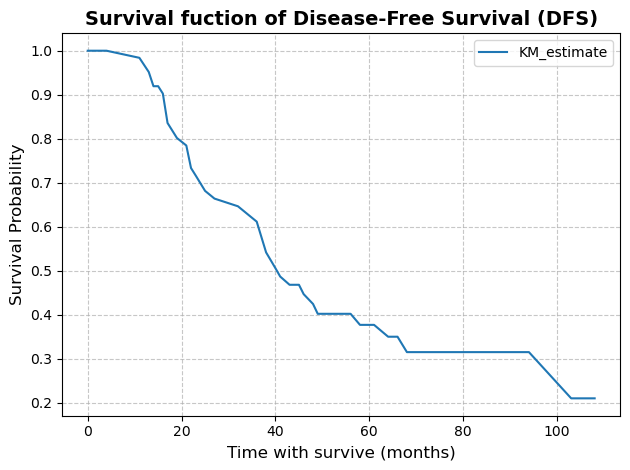

In [15]:
kmf.survival_function_.plot();
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Error bars**

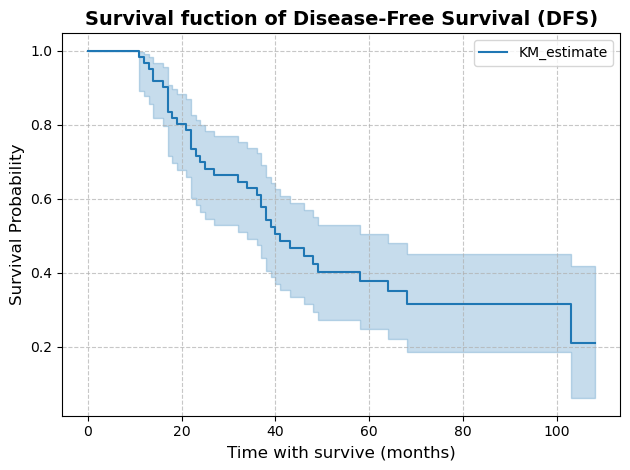

In [16]:
kmf.plot_survival_function()
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Cox proportional hazards model**

In [17]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(cancer_df_surv, duration_col="DFS (in months)", event_col="DFS event")

<lifelines.CoxPHFitter: fitted with 63 total observations, 25 right-censored observations>

<Axes: xlabel='log(HR) (95% CI)'>

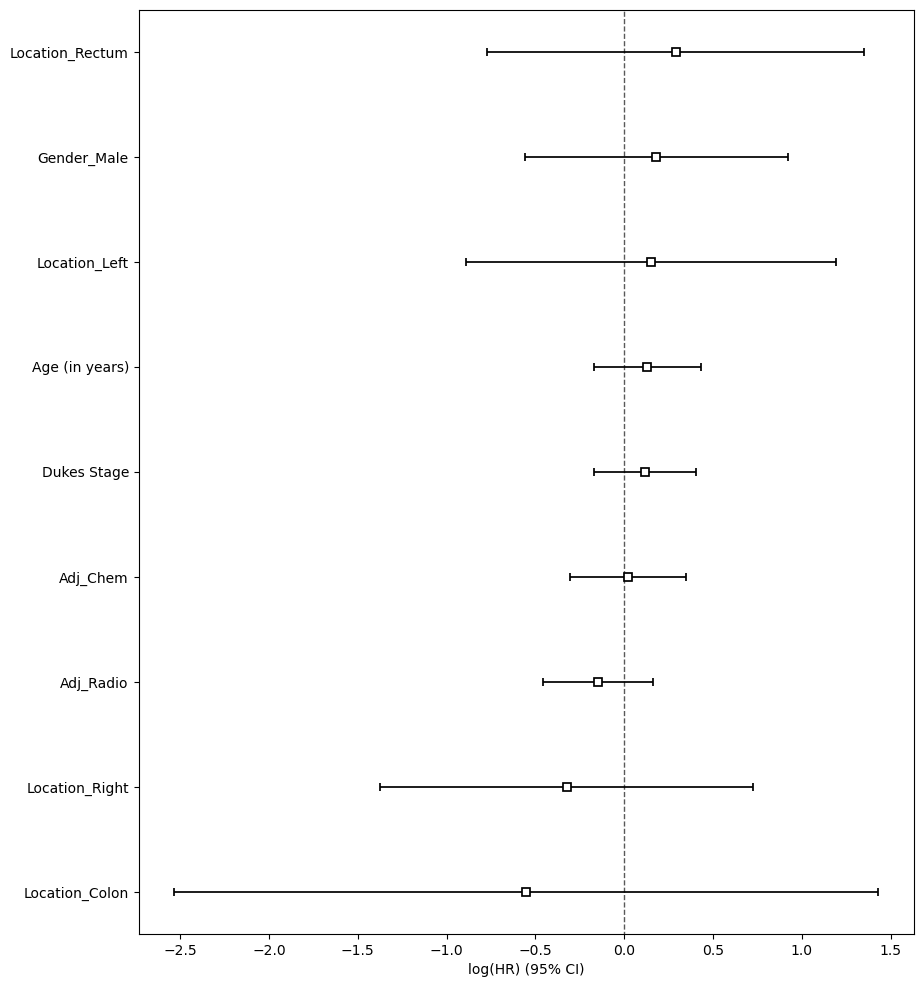

In [18]:
plt.figure(figsize=(10, 12))
cph.plot()

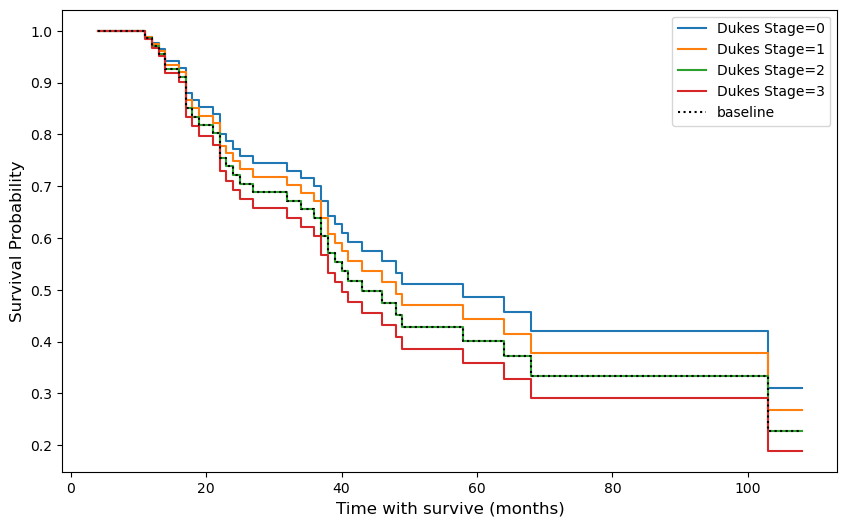

In [19]:
cph.plot_partial_effects_on_outcome("Dukes Stage", [0, 1, 2, 3])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)